In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Acquire the data

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

## EDA

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


#### Show Images

Use the PIL (Python Imaging Library) library to print images under a python console. They need to be in a 'printable' format like jpeg, png etc

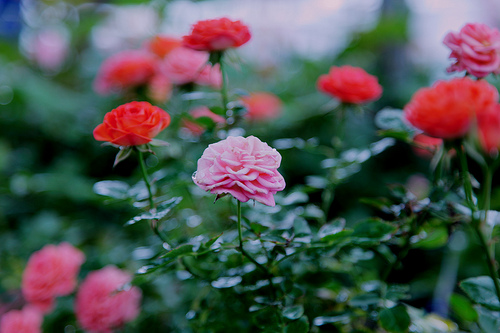

In [4]:
# Printing some roses from Roses folder under the data
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

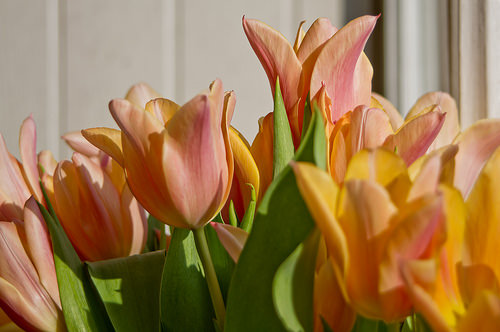

In [5]:
# And, some tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## Convert Images to TF Dataset using Keras

In [6]:
# Define user inputs

batch_size = 32
img_height = 180
img_width = 180

In [7]:
# Create the training dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
                                                        data_dir,
                                                        validation_split=0.2,
                                                        subset="training",
                                                        seed=123,
                                                        image_size=(img_height, img_width),
                                                        batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
                                                      data_dir,
                                                      validation_split=0.2,
                                                      subset="validation",
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
# Print class names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [10]:
# Let's understand the data array wise

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The output is (32, 180, 180, 3) - 

32 - Batch Size

180 - Height

180 - Width

3 - Number of color channels (3 for RGB)

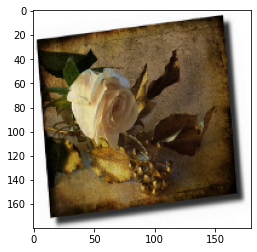

In [11]:
# Let's print 1st image in the batch
# Notice how we use Matplotlib to print an array of an image
plt.imshow(tf.keras.preprocessing.image.array_to_img(image_batch[0]))

## Performance Tuning : Dataset

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

### Rescaling Layer

Before we start off creating the model, let's explore rescaling - 

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
# In case we want to apply the rescaling directly to the dataset, we can map the lambda function to the dataset

normalized_ds = train_ds.map(lambda x, y : (normalization_layer(x), y))

image_batch, label_batch = next(iter(normalized_ds))

first_image = image_batch[0]

# First few rows of the array
print(first_image[0][0:5], label_batch[0])

# Min and Max value in the image array
print(np.min(first_image), np.max(first_image))

tf.Tensor(
[[0.3911402  0.29429922 0.21387075]
 [0.55098045 0.44662312 0.33529413]
 [0.61216414 0.5019245  0.41067544]
 [0.5737836  0.49379086 0.40214235]
 [0.59084976 0.52156866 0.4150327 ]], shape=(5, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int32)
0.0 1.0


In [15]:
# The other way would be to just add a Rescaling layer in the model. We use that approach

### Define the model

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu').

In [16]:
num_classes = len(class_names) #train_ds.class_names

model = Sequential([
                    layers.Rescaling(1./255 , input_shape = (img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(128, activation = 'relu'),
                    layers.Dense(num_classes)
])

### Compile the model

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 105s 1s/step - loss: 1.4725 - accuracy: 0.3713 - val_loss: 1.1344 - val_accuracy: 0.5341
Epoch 2/10
92/92 [==============================] - 95s 1s/step - loss: 1.0275 - accuracy: 0.5903 - val_loss: 0.9690 - val_accuracy: 0.6172
Epoch 3/10
92/92 [==============================] - 94s 1s/step - loss: 0.8762 - accuracy: 0.6597 - val_loss: 1.0153 - val_accuracy: 0.5899
Epoch 4/10
92/92 [==============================] - 93s 1s/step - loss: 0.6831 - accuracy: 0.7558 - val_loss: 0.8706 - val_accuracy: 0.6676
Epoch 5/10
92/92 [==============================] - 94s 1s/step - loss: 0.4866 - accuracy: 0.8283 - val_loss: 0.9061 - val_accuracy: 0.6594
Epoch 6/10
92/92 [==============================] - 94s 1s/step - loss: 0.3255 - accuracy: 0.8937 - val_loss: 1.0592 - val_accuracy: 0.6376
Epoch 7/10
92/92 [==============================] - 94s 1s/step - loss: 0.1723 - accuracy: 0.9445 - val_loss: 1.2484 - val_accuracy: 0.6540
Epoch 8/10
92/92 [=

### Visualize training results

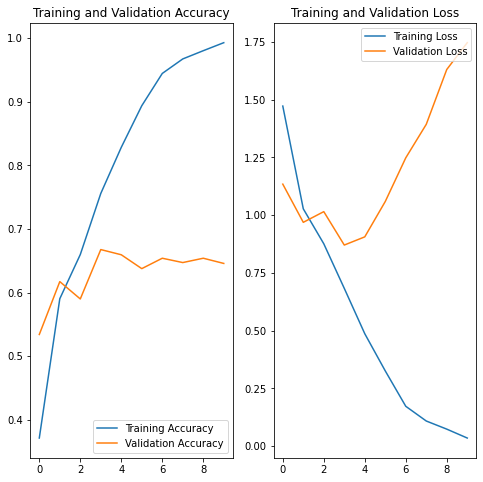

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show() 

Boy that model overfit a lot !!!!

The model is performing increasingly well on the training data, but the performance doesn't increase as much on the validation data set. This is clearly one of the signs to identify Overfitting. Increasing validation loss doesn't help at all!

The model learns training data very well, but doesn't seem to perform as good on unseen data and chances are won't perform well in production as well. 

Some strategies to tackle Overfitting are - 

* Get more data - Always the solution
* Data Augmentation - Create new training data with the help of existing - flip the images, create subsets of the input text and likewise
* Use other architecture - Maybe the model is too complex for the problem
* Dropout, Regularization
* Remove redundant features - Check if passing correlated features
* Early Stopping
* Ensembling - Too many cooks ruin the dish!

## Model Approach 2

### Data Augmentation

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [22]:
# .take(1) returns first batch - 32 images from the training dataset
len(data_augmentation([i for i, j in train_ds.take(1)]))

32

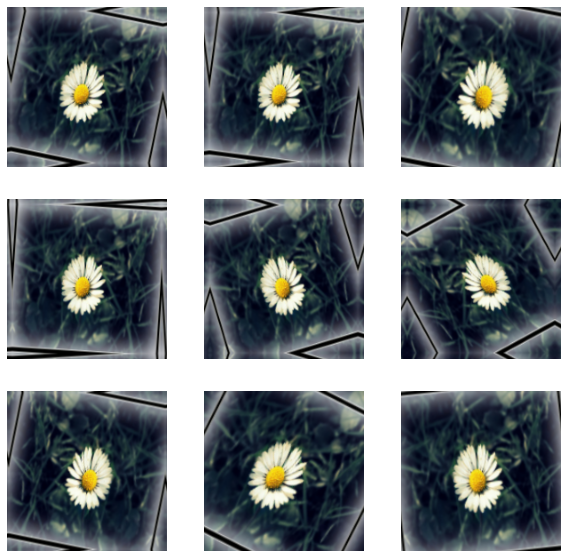

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
# This layer can help create artificial dataset by randomly flipping, zooming in on the images

### DropOut

As per Google - A form of regularization useful in training neural networks. Dropout regularization removes a random selection of a fixed number of the units in a network layer for a single gradient step. The more units dropped out, the stronger the regularization. This is analogous to training the network to emulate an exponentially large ensemble of smaller networks. 


When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. `Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.`

### Define the model

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Train the model

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 110s 1s/step - loss: 1.3899 - accuracy: 0.4162 - val_loss: 1.1311 - val_accuracy: 0.5109
Epoch 2/15
92/92 [==============================] - 108s 1s/step - loss: 1.0467 - accuracy: 0.5923 - val_loss: 1.0178 - val_accuracy: 0.6144
Epoch 3/15
92/92 [==============================] - 109s 1s/step - loss: 0.9521 - accuracy: 0.6311 - val_loss: 0.9215 - val_accuracy: 0.6308
Epoch 4/15
92/92 [==============================] - 110s 1s/step - loss: 0.8685 - accuracy: 0.6686 - val_loss: 0.9534 - val_accuracy: 0.6526
Epoch 5/15
92/92 [==============================] - 114s 1s/step - loss: 0.8203 - accuracy: 0.6846 - val_loss: 0.8294 - val_accuracy: 0.6689
Epoch 6/15
92/92 [==============================] - 109s 1s/step - loss: 0.7824 - accuracy: 0.7040 - val_loss: 0.8380 - val_accuracy: 0.6907
Epoch 7/15
92/92 [==============================] - 109s 1s/step - loss: 0.7633 - accuracy: 0.7057 - val_loss: 0.8658 - val_accuracy: 0.6526
Epoch 8/15
92

### Visualize Training Results

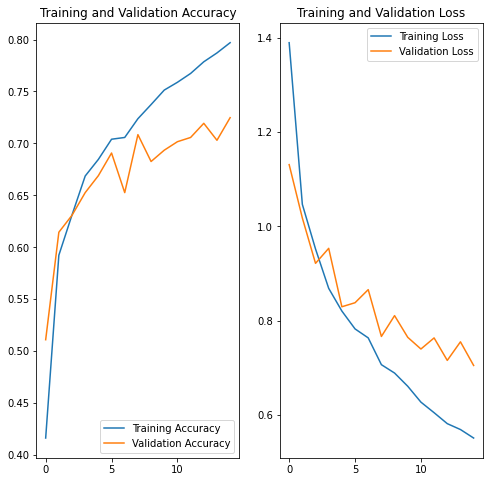

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predictions

Data Augmentation and DropOut helped with Overfitting. Now we can use the model to make predictions on unseen data

### Get image

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)


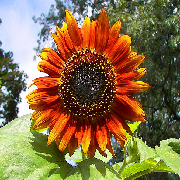

In [31]:
# Let's see what it looks like

img

In [32]:
# Oohh, definitely, Sunflower!

### 1 last step before predicting - shape!

While training the model, we provided the input size as (batch, img_height, img_width, 3)
Now that we have downloaded the image, we ensured that the target size is (img_height, img_width, 3), but still the data needs to batched first

In [33]:
# Create a batch
img_array = tf.expand_dims(img_array, 0)

In [34]:
predictions = model.predict(img_array)
predictions

array([[-4.089084 , -1.6119614, -1.563128 ,  6.4770436,  2.9094548]],
      dtype=float32)

In [35]:
# Apply Softmax to convert model score to probabilities
score = tf.nn.softmax(predictions[0]) # predictions[0] since we only have 1 example
score

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([2.5050984e-05, 2.9828111e-04, 3.1320855e-04, 9.7193176e-01,
       2.7431631e-02], dtype=float32)>

In [36]:
# The model outputs an array of size (num_classes) which is the array of class probabilities that model predicts.
# In order to pick the output, we need to choose the class with the highest score (probability)

In [37]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 97.19 percent confidence.
